In [45]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, accuracy_score, precision_score, recall_score

# decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# random forest
from sklearn.ensemble import RandomForestClassifier

# xgboost
from xgboost import XGBClassifier

import shap

### Loading in the dataset

In [46]:
df = pd.read_csv('Telco-Customer-Churn.csv')
print(df.head())
print(df.info())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [47]:
df['customerID'].nunique()

7043

### Clean and split the data

In [48]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# Convert categorical variables to numerical
# Binary vars
binary_cols = []

for col in df.columns:
    if df[col].nunique() == 2:
        binary_cols.append(col)

for col in binary_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Cols with more than 2 categories
cat_cols = [col for col in df.columns if df[col].nunique() > 2 and not is_numeric_dtype(df[col]) and col not in ['customerID']]
cat_cols

df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customerID                             7043 non-null   object 
 1   gender                                 7043 non-null   int64  
 2   SeniorCitizen                          7043 non-null   int64  
 3   Partner                                7043 non-null   int64  
 4   Dependents                             7043 non-null   int64  
 5   tenure                                 7043 non-null   int64  
 6   PhoneService                           7043 non-null   int64  
 7   PaperlessBilling                       7043 non-null   int64  
 8   MonthlyCharges                         7043 non-null   float64
 9   TotalCharges                           7043 non-null   float64
 10  Churn                                  7043 non-null   int64  
 11  Mult

In [49]:
customer_ids = df['customerID']
df = df.drop(columns=['customerID'])

In [50]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(X, y, customer_ids, test_size=0.2,random_state=42)

In [51]:
# Use class weights to address class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print("Class distribution in training set:")
print(y_train.value_counts(normalize=True))


Class distribution in training set:
Churn
0    0.734469
1    0.265531
Name: proportion, dtype: float64


### Model Training

#### Decision Tree

Fitting 5 folds for each of 60 candidates, totalling 300 fits


Best Parameters: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best Cross-Validation F1: 0.612250994539461

Confusion Matrix:
 [[755 281]
 [ 78 295]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.73      0.81      1036
           1       0.51      0.79      0.62       373

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.75      0.76      1409

Test Accuracy: 0.6217070600632244


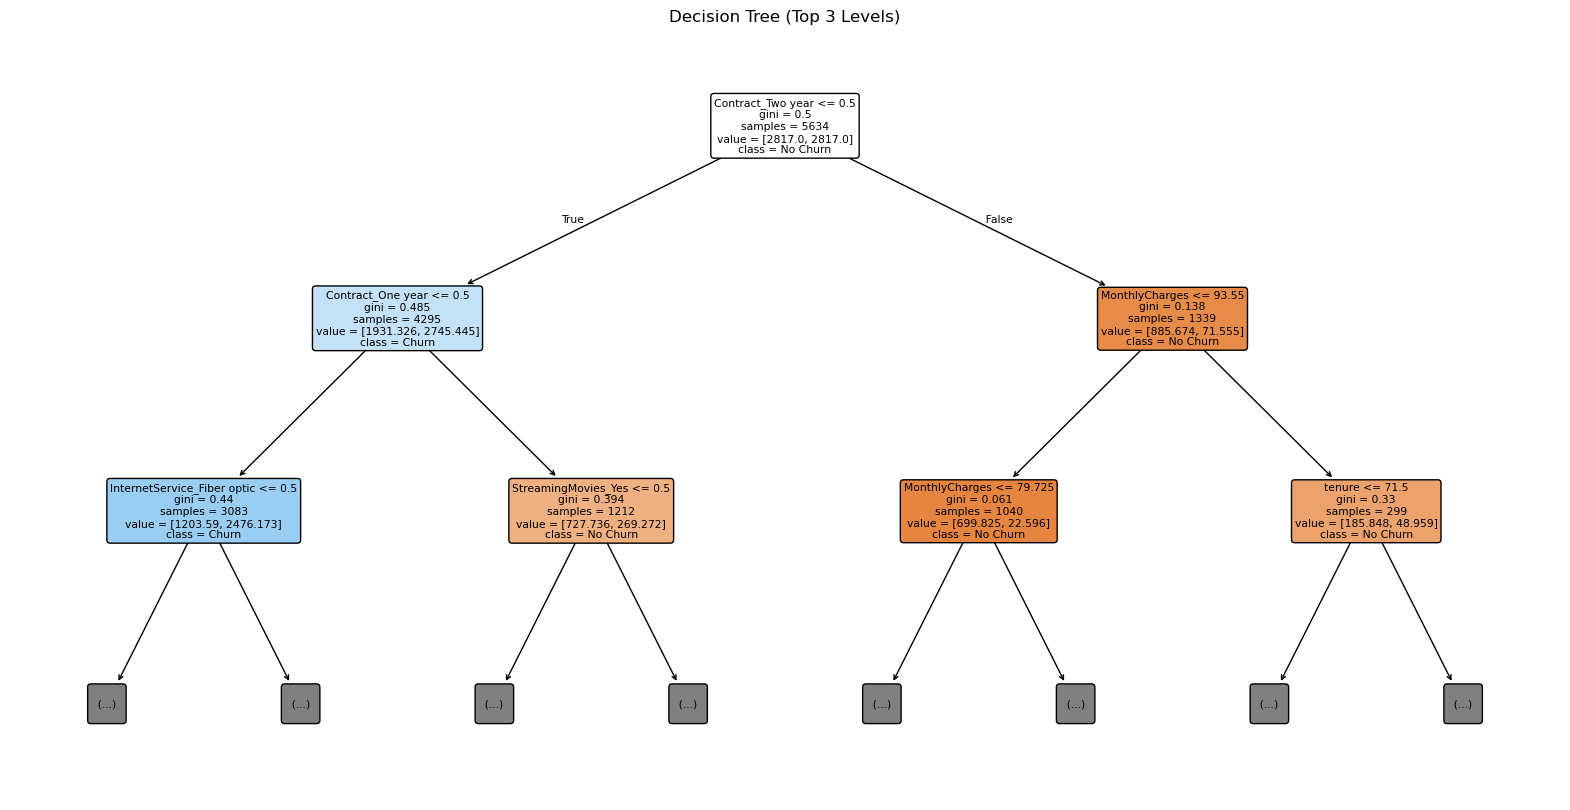

In [52]:
dt_weighted = DecisionTreeClassifier(random_state=42, class_weight=class_weight_dict)

# Hyperparameter tuning 
param_grid_weighted = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10]
}

grid_search_weighted = GridSearchCV(
    dt_weighted, 
    param_grid_weighted, 
    cv=5, 
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search_weighted.fit(X_train, y_train)

best_dt = grid_search_weighted.best_estimator_

y_pred_weighted = best_dt.predict(X_test)

# Results
print("Best Parameters:", grid_search_weighted.best_params_)
print("Best Cross-Validation F1:", grid_search_weighted.best_score_)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_weighted))
print("\nClassification Report:\n", classification_report(y_test, y_pred_weighted))
print("Test Accuracy:", f1_score(y_test, y_pred_weighted))

best_dt = grid_search_weighted.best_estimator_

# visualize tree
plt.figure(figsize=(20, 10))  
plot_tree(best_dt, 
          feature_names=X_train.columns, 
          class_names=['No Churn', 'Churn'], 
          filled=True, 
          rounded=True, 
          max_depth=2)
plt.title("Decision Tree (Top 3 Levels)")
plt.savefig('decision_tree.png')


#### Random Forest

In [53]:
rf = RandomForestClassifier(random_state=42, class_weight=class_weight_dict)

param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'max_features': ['sqrt', 'log2']
}

rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

# Evaluate on test set
y_pred = best_rf.predict(X_test)

print("\n=== F1-score Tuned Model ===")
print("Best Params:", rf_grid.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 54 candidates, totalling 270 fits

=== F1-score Tuned Model ===
Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.78      0.84      1036
           1       0.56      0.78      0.65       373

    accuracy                           0.78      1409
   macro avg       0.74      0.78      0.75      1409
weighted avg       0.82      0.78      0.79      1409

Confusion Matrix:
 [[812 224]
 [ 83 290]]


#### XGBoost

In [54]:
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos  # for class imbalance

xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    use_label_encoder=False
)

# Train 
xgb.fit(X_train, y_train)

# Evaluate
y_pred = xgb.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



/opt/anaconda3/envs/trees_project/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:53] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.81      0.84      1036
           1       0.56      0.70      0.62       373

    accuracy                           0.78      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.80      0.78      0.78      1409

Confusion Matrix:
 [[834 202]
 [113 260]]


### Evaluate Model Performance


=== Decision Tree ===
Accuracy : 0.7452
Precision: 0.5122
Recall   : 0.7909
F1-score : 0.6217
Confusion Matrix:
 [[755 281]
 [ 78 295]]

=== Random Forest ===
Accuracy : 0.7821
Precision: 0.5642
Recall   : 0.7775
F1-score : 0.6539
Confusion Matrix:
 [[812 224]
 [ 83 290]]

=== XGBoost ===
Accuracy : 0.7764
Precision: 0.5628
Recall   : 0.6971
F1-score : 0.6228
Confusion Matrix:
 [[834 202]
 [113 260]]


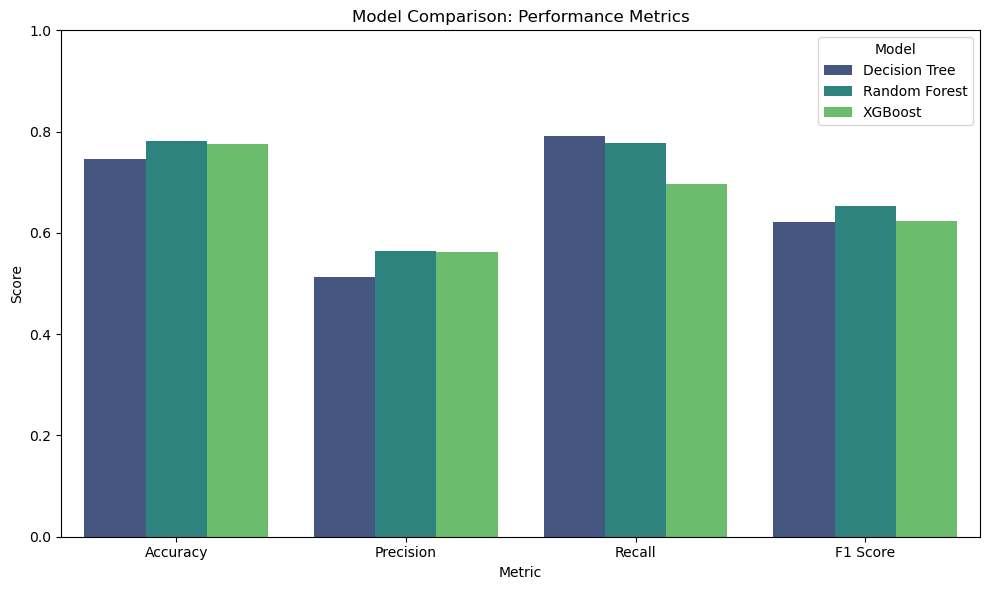

<Figure size 640x480 with 0 Axes>

In [55]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n=== {name} ===")
    print("Accuracy :", round(accuracy_score(y_true, y_pred), 4))
    print("Precision:", round(precision_score(y_true, y_pred), 4))
    print("Recall   :", round(recall_score(y_true, y_pred), 4))
    print("F1-score :", round(f1_score(y_true, y_pred), 4))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# Decision Tree
evaluate_model("Decision Tree", y_test, y_pred_weighted)

# Random Forest
evaluate_model("Random Forest", y_test, best_rf.predict(X_test))

# XGBoost
evaluate_model("XGBoost", y_test, xgb.predict(X_test))


# Graph
metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

models = {
    'Decision Tree': y_pred_weighted,
    'Random Forest': best_rf.predict(X_test),
    'XGBoost': xgb.predict(X_test)
}

for name, y_pred in models.items():
    metrics['Model'].append(name)
    metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['Precision'].append(precision_score(y_test, y_pred))
    metrics['Recall'].append(recall_score(y_test, y_pred))
    metrics['F1 Score'].append(f1_score(y_test, y_pred))

df_metrics = pd.DataFrame(metrics)
df_melted = df_metrics.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Metric', y='Score', hue='Model', palette='viridis')
plt.title('Model Comparison: Performance Metrics')
plt.ylim(0, 1)
plt.legend(title='Model')
plt.tight_layout()
plt.show()
plt.savefig('model_comparison.png')


### SHAP Analysis

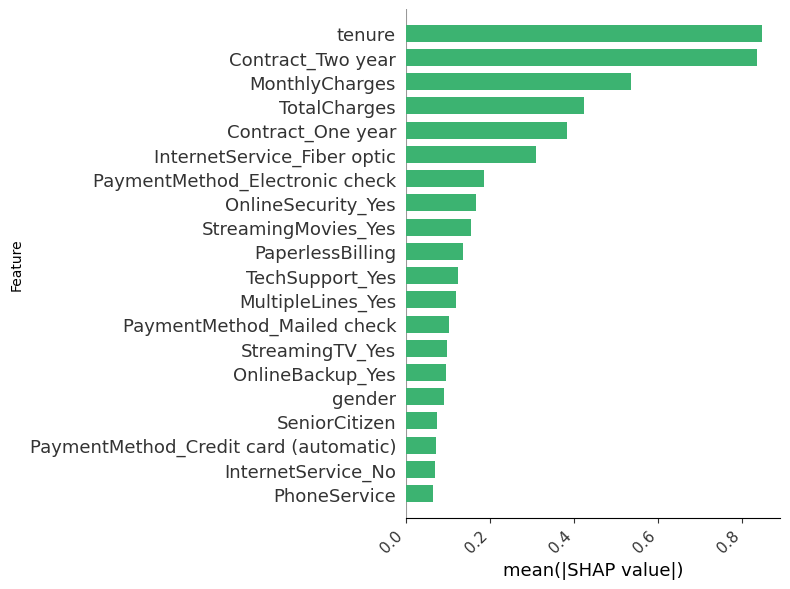

<Figure size 640x480 with 0 Axes>

In [56]:
explainer = shap.Explainer(xgb)

shap_values = explainer(X_test)

# global feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar", plot_size=(8, 6), show=False, color='mediumseagreen')

plt.xticks(rotation=45, ha='right')
plt.xlabel("mean(|SHAP value|)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
plt.savefig('shap_summary_bar.png')


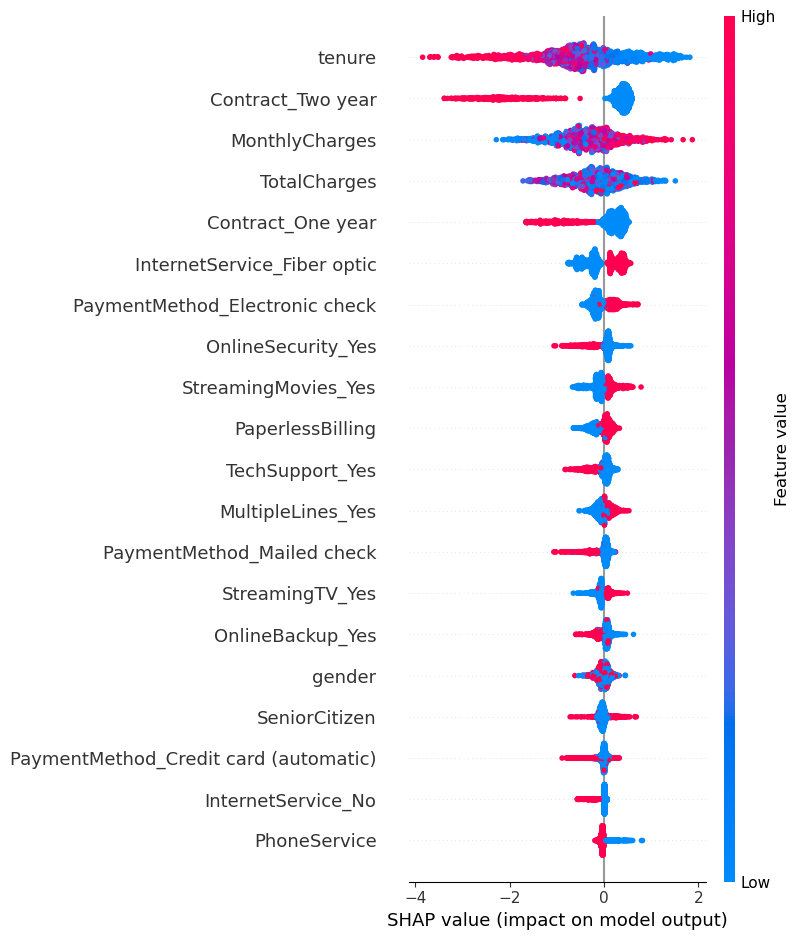

<Figure size 640x480 with 0 Axes>

In [57]:
# More detailed summary (how features impact predictions)
shap.summary_plot(shap_values, X_test)
plt.savefig('shap_summary_detail.png')